# 02 - Evaluating the Xception Model

Due to its ***Xceptional*** (*pun intended*) performance, I want to further break down the performance of the Xception model. I will also use this one to generate predictions and link it to the Streamlit app in the following notebooks. <br>

In the medical field, accuracy alone is not enough to claim success of a model. This is especially true when we have multiple classes present. For example, maybe we're 100% correct in predicting one class, but the remaining misclassified predictions are affecting our ability to predict another class. This is why we need to assess model's performance further on precision and recall. <br> 

**Precision** can be thought of as the accuracy of our accurate predictions. In other words, of all the predictions we claimed belong to a certain class, how many of them are actually accurate?

**Recall**, on the other hand, is a measure of how many instances of a class we correctly identified as belonging to that class. 

---
## 1. Recreating `test_data_gen` Dataset

The Xception model was saved, so I can import that here. However, I need to recreate the `test_data_gen` dataset using `ImageDataGenerator()` again since I'm working in a new environment. The remainder of the work will be done in Jupyter Lab, ***not Google Colab***.

In [4]:
# to start, I just need to recreate the test_data_gen since new notebook, new environment

# imports!
# basic imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# os & image imports
import os
from PIL import Image

# tensorflow
import tensorflow as tf

# keras
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.metrics import Precision, Recall, SpecificityAtSensitivity, SensitivityAtSpecificity

# sklearn
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.model_selection import train_test_split # need this to split the train set into train/test for model training
from sklearn.metrics import precision_score, recall_score, classification_report

In [5]:
# test directory
test_directory = './data/archive/Testing'

In [6]:
# same function as before
def image_to_df(filepath):

    base = os.listdir(filepath)
    base.remove('.DS_Store') # removes this element from the list, remaining should be the actual folders

    label = []
    img_path = []
    folder_path = []

    for folder_name in base:
        images = os.listdir(filepath + f'/{folder_name}')
        for i in images:
            if i.endswith(".jpg"):
                label.append(folder_name)
                img_path.append(f'{filepath}/{folder_name}/{i}')
                folder_path.append(f'{filepath}/{folder_name}')

    return pd.DataFrame(data={'folder_path': folder_path,'img_path': img_path, 'label': label})

In [36]:
# storing the output of the function for test data
test_df = image_to_df(test_directory)

test_df.head()

,folder_path,img_path,label
0,./data/archive/Testing/pituitary,./data/archive/Testing/pituitary/Te-pi_0233.jpg,pituitary
1,./data/archive/Testing/pituitary,./data/archive/Testing/pituitary/Te-pi_0227.jpg,pituitary
2,./data/archive/Testing/pituitary,./data/archive/Testing/pituitary/Te-pi_0019.jpg,pituitary
3,./data/archive/Testing/pituitary,./data/archive/Testing/pituitary/Te-pi_0031.jpg,pituitary
4,./data/archive/Testing/pituitary,./data/archive/Testing/pituitary/Te-pi_0025.jpg,pituitary


In [37]:
test_df['img_path']

0         ./data/archive/Testing/pituitary/Te-pi_0233.jpg
1         ./data/archive/Testing/pituitary/Te-pi_0227.jpg
2         ./data/archive/Testing/pituitary/Te-pi_0019.jpg
3         ./data/archive/Testing/pituitary/Te-pi_0031.jpg
4         ./data/archive/Testing/pituitary/Te-pi_0025.jpg
                              ...                        
1306     ./data/archive/Testing/meningioma/Te-me_0080.jpg
1307     ./data/archive/Testing/meningioma/Te-me_0094.jpg
1308     ./data/archive/Testing/meningioma/Te-me_0137.jpg
1309     ./data/archive/Testing/meningioma/Te-me_0123.jpg
1310    ./data/archive/Testing/meningioma/Te-meTr_0009...
Name: img_path, Length: 1311, dtype: object

In [8]:
# instantiate generator for test 
idg_test = ImageDataGenerator(rescale = 1./255,) #only the rescaling is needed

test_data_gen = idg_test.flow_from_dataframe(test_df,
                             x_col = 'img_path',
                             y_col = 'label',
                             class_mode = 'categorical',
                             target_size = (256,256),
                             batch_size = 32,
                             color_mode = 'rgb',
                             shuffle = False,
                             classes = {'notumor': 0, 'glioma': 1, 'meningioma': 2, 'pituitary': 3}) # setting the default class indices

Found 1311 validated image filenames belonging to 4 classes.


---
## 2. Evaluating Performance

In [9]:
# load Xception model
xception = tf.keras.models.load_model('./assets/cnn_models/model2.h5')

### 2a. Regenerate the predictions

In [10]:
pred_probs = xception.predict(test_data_gen)

41/41 [==============================] - 99s 2s/step


In [12]:
# convert probabilities into single list of predictions
preds = np.argmax(pred_probs, axis = 1)
preds

array([3, 3, 1, ..., 2, 2, 2])

In [13]:
y_test = test_data_gen.classes

In [14]:
# overall roughly 95% accuracy
(preds == y_test).mean()

0.9511823035850496

In [15]:
precision_score(y_test, preds, average=None, )

array([0.99012346, 0.86127168, 0.96283784, 0.99621212])

In [16]:
recall_score(y_test, preds, average = None, )

array([0.99012346, 0.99333333, 0.93137255, 0.87666667])

In [17]:
summary = pd.DataFrame(classification_report(y_test, preds, output_dict = True))
summary.rename({'0': 'notumor', '1': 'glioma', '2': 'meningioma', '3': 'pituitary'}, axis = 1, inplace = True)

In [18]:
summary

,notumor,glioma,meningioma,pituitary,accuracy,macro avg,weighted avg
precision,0.990123,0.861272,0.962838,0.996212,0.951182,0.952611,0.955662
recall,0.990123,0.993333,0.931373,0.876667,0.951182,0.947874,0.951182
f1-score,0.990123,0.922601,0.946844,0.932624,0.951182,0.948048,0.951412
support,405.000000,300.000000,306.000000,300.000000,0.951182,1311.000000,1311.000000


In [19]:
test_df.iloc[0,2]

'pituitary'

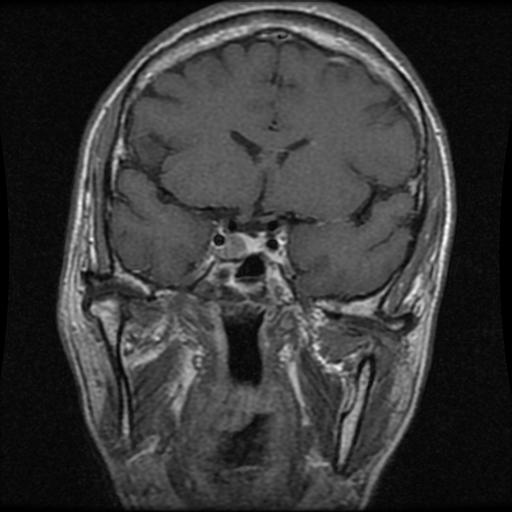

In [20]:
image = Image.open(f'{test_df.iloc[0,1]}') # open the image
image

In [21]:
image = image.resize((256,256)) # resize to 256x256
image = image.convert('RGB') # convert all to RGB
image = np.array(image) / 255. # turn image into an array of matrices & rescale!

In [22]:
image = np.expand_dims(image, axis = 0) ## this is crucial --> needed to expand the dim from (256, 256, 3) to (1, 256, 256, 3)
# the (1) denotes the batch size, in this case the size is just 1

In [23]:
image.shape

(1, 256, 256, 3)

In [32]:
sample_pred = xception.predict(image)

1/1 [==============================] - 0s 117ms/step


In [33]:
sample_pred

array([[8.9704525e-05, 2.4924270e-04, 1.9239680e-03, 9.9773705e-01]],
      dtype=float32)

In [34]:
sample_pred = np.argmax(sample_pred, axis =1)

In [35]:
dict_[sample_pred[0]]

'pituitary'

In [29]:
dict_ = {}
for k, v in test_data_gen.class_indices.items():
    dict_.update({v:k})

# unnecessary for actual 03 NB

In [30]:
dict_

{0: 'notumor', 1: 'glioma', 2: 'meningioma', 3: 'pituitary'}